# Sobel Pipeline on PYNQ-Z1

In this notebook, the sobel filter will be applied on USB camera input on the PL side and displayed on the notebook.

In [1]:
%matplotlib inline

import os
from pynq import Overlay
from pynq import allocate
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

## 1. Load the overlay

Sobel pipeline overlay is loaded on the PL side.

In [2]:
overlay = Overlay("/home/xilinx/custom_overlays/sobel_pipeline_rgb.bit")

if overlay.is_loaded():
    dma_send = overlay.dma_to_pipeline
    dma_recv = overlay.dma_from_pipeline
else:
    assert False, "Overlay not loaded."

## 2. Setup the USB camera

The USB camera is opened and configured.

In [3]:
os.environ["OPENCV_LOG_LEVEL"] = "SILENT"

videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
videoIn.set(cv2.CAP_PROP_BUFFERSIZE, 2)

print("Camera is open: " + str(videoIn.isOpened()))

[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (616) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


Camera is open: True


## 3. Create pipeline functions

Functions to run the pipeline are created.

In [4]:
import time
def transfer_frame(frame):

    meta = {}

    start = time.time()

    # Buffers must have 64-bit data
    in_buffer = allocate(shape=(640*480,), dtype=np.uint64)
    out_buffer = allocate(shape=(640*480,), dtype=np.uint64)

    meta["allocate"] = time.time() - start
    start = time.time()

    # Copy the frame to input buffer
    for row in range(480):
        for col in range(640):
            r = frame[row, col, 0] << 16
            g = frame[row, col, 1] << 8
            b = frame[row, col, 2]
            in_buffer[row * 640 + col] = r + g + b

    meta["copy input"] = time.time() - start
    start = time.time()

    # Send the input frame and receive the filtered frame
    dma_send.sendchannel.transfer(in_buffer)
    dma_recv.recvchannel.transfer(out_buffer)
    dma_send.sendchannel.wait()
    dma_recv.recvchannel.wait()

    meta["transfer"] = time.time() - start
    start = time.time()

    # Copy the output buffer to frame
    out_frame = np.ndarray((480, 640, 3), dtype=np.uint8)
    for row in range(480):
        for col in range(640):
            hex_str = "{0:0{1}X}".format(out_buffer[row * 640 + col], 6)
            out_frame[row, col, 0] = int(hex_str[0:2], 16)
            out_frame[row, col, 1] = int(hex_str[2:4], 16)
            out_frame[row, col, 2] = int(hex_str[4:6], 16)

    meta["copy output"] = time.time() - start

    del in_buffer
    del out_buffer
    return out_frame, meta


def print_frame(frame):
    clear_output(wait=True)
    plt.figure(1, figsize=(10, 10))
    plt.imshow(frame)
    plt.show()


def run_pipeline():
    while True:
        ret, frame = videoIn.read()
        if ret:
            frame, meta = transfer_frame(frame)
            print_frame(frame)
            for k, v in meta.items():
                print("{}: {}".format(k, v))

## 4. Start the pipeline

The pipeline starts running.

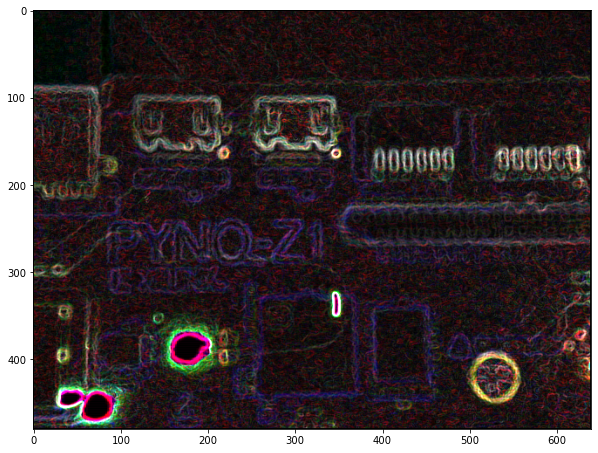

allocate: 0.036289215087890625
copy input: 41.21281886100769
transfer: 0.013343334197998047
copy output: 15.070146560668945


In [5]:
run_pipeline()